# CCP LifeTime Analysis
## Convert Imaris Tracking Result to Lifetime

✅Update time interval here.

## 1. Define variables and Install dependencies
###  Set time interval of the movie here.

In [2]:
import os
import pandas as pd
import re
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import warnings

#User definable variable
Time_interval  =  2.136

## 2. Load Imaris tracking result and correct the track number according to the probability density function

### 2.1 DATA IO
✅ Set "Path" for Imaris measurements and output.

In [3]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Get the path for loading & saving data
Path_Raw = "/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/A_Imaris result/Slow/GFP04-2_interval_2p136.xls"
# Save the result to the same foler
Path_Result = "/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/B_Same speed/Slow/CorrectedTrackNo_4_2.xlsx"

### 2.2 Test for data retrival

In [5]:
 # Load Data
Table_Raw = pd.read_excel(Path_Raw, sheet_name=["Time Index", "Track Duration", "Track Number of Spots"], header = 1)
Table_Raw

{'Time Index':        Time Index  Unit Category  Time       TrackID     ID
 0               1   NaN     Spot     1  1.000000e+09      1
 1               1   NaN     Spot     1  1.000000e+09      3
 2               1   NaN     Spot     1  1.000000e+09      4
 3               1   NaN     Spot     1  1.000000e+09      5
 4               1   NaN     Spot     1  1.000000e+09      7
 ...           ...   ...      ...   ...           ...    ...
 20812         286   NaN     Spot   286  1.000050e+09  57194
 20813         286   NaN     Spot   286  1.000050e+09  57198
 20814         286   NaN     Spot   286  1.000055e+09  57199
 20815         286   NaN     Spot   286  1.000055e+09  57213
 20816         286   NaN     Spot   286  1.000057e+09  57220
 
 [20817 rows x 6 columns],
 'Track Duration':      Track Duration Unit Category          ID
 0                 5    s    Track  1000000001
 1                 1    s    Track  1000000003
 2                 4    s    Track  1000000004
 3                 

### 2.3 Setup for the data architecture

In [6]:
# New architecture
Temp_DF = Table_Raw["Track Duration"]
Temp_DF["Track number of Spots"] = Table_Raw["Track Number of Spots"]["Track Number of Spots"]
Temp_DF


,Track Duration,Unit,Category,ID,Track number of Spots
0,5,s,Track,1000000001,6
1,1,s,Track,1000000003,2
2,4,s,Track,1000000004,5
3,2,s,Track,1000000005,3
4,184,s,Track,1000000007,185
...,...,...,...,...,...
769,2,s,Track,1000056450,3
770,3,s,Track,1000056573,4
771,1,s,Track,1000056575,2
772,2,s,Track,1000056708,3


### 2.4 Remove the tracks crossing over the head and the end of the movie

In [7]:
# Filter the tracks crossing over head and end
Time_min = Table_Raw["Time Index"]["Time Index"].min()
Time_max = Table_Raw["Time Index"]["Time Index"].max()
Movie_length = Time_max - Time_min + 1
Outlier_ID = (Table_Raw["Time Index"]["Time Index"] <= Time_min) | (Table_Raw["Time Index"]["Time Index"] >= Time_max)# To creat mask for Outlier of TrackID
#Test_Outlier_ID = Table_Raw["Time Index"][Outlier_ID]
Outlier_ID = Table_Raw["Time Index"]["TrackID"][Outlier_ID]# Apply the mask to fetch real set
Outlier_ID = set(Outlier_ID)# to remove duplicates
Final =Temp_DF[ ~Temp_DF["ID"].isin(Outlier_ID)]# filtering TrackID by set(Outlier_ID) to get Final table
Final

,Track Duration,Unit,Category,ID,Track number of Spots
70,1,s,Track,1000000221,2
71,13,s,Track,1000000241,14
72,62,s,Track,1000000286,60
73,7,s,Track,1000000315,8
74,155,s,Track,1000000341,153
...,...,...,...,...,...
761,6,s,Track,1000055617,7
762,6,s,Track,1000055631,7
765,1,s,Track,1000056061,2
769,2,s,Track,1000056450,3


### 2.5 Get final analysis result

In [8]:
#Collect the final data ------------------------------------------------------------------------
Track_Summary = Final.copy()
Track_Summary["Measured Track No"] = 1
Track_Summary = Track_Summary.groupby("Track Duration").sum().reset_index()
Track_Summary = Track_Summary.drop(columns=["ID", "Unit", "Category"])
Track_Summary["cf"] = Movie_length/(Movie_length-1- Track_Summary["Track Duration"] )
Track_Summary["Corrected Track No"] = Track_Summary["Measured Track No"]*Track_Summary["cf"]
Track_Summary["Time interval"] = Time_interval
Track_Summary["Lifetime"] = Track_Summary["Track Duration"]*Time_interval
Track_Summary["Normalized spots population"] = Track_Summary["Track number of Spots"].apply(lambda x: x/ Track_Summary["Track number of Spots"].sum())
Track_Summary["Normalized track population"] = Track_Summary["Corrected Track No"].apply(lambda x: x/ Track_Summary["Corrected Track No"].sum())
Track_Summary


,Track Duration,Track number of Spots,Measured Track No,cf,Corrected Track No,Time interval,Lifetime,Normalized spots population,Normalized track population
0,1,132,66,1.007042,66.464789,2.136,2.136,0.009630,0.093360
1,2,191,70,1.010601,70.742049,2.136,4.272,0.013934,0.099368
2,3,103,28,1.014184,28.397163,2.136,6.408,0.007514,0.039888
3,4,154,33,1.017794,33.587189,2.136,8.544,0.011235,0.047179
4,5,212,39,1.021429,39.835714,2.136,10.680,0.015467,0.055956
...,...,...,...,...,...,...,...,...,...
90,155,153,1,2.200000,2.200000,2.136,331.080,0.011162,0.003090
91,156,156,1,2.217054,2.217054,2.136,333.216,0.011381,0.003114
92,161,158,1,2.306452,2.306452,2.136,343.896,0.011527,0.003240
93,179,179,1,2.698113,2.698113,2.136,382.344,0.013059,0.003790


### 2.6 Save the analysis result

In [9]:
Track_Summary.to_excel(Path_Result)
print("Table created here: %s" %(Path_Result))

Table created here: /content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/B_Same speed/Slow/CorrectedTrackNo_4_2.xlsx


### 2.7 Plot the merged data

Analyzed track no. = 711.9171705404125


Text(0.5, 1.0, 'Track # vs Lifetime')

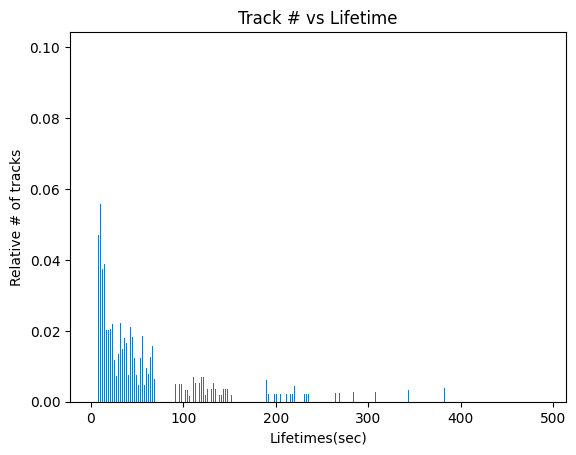

In [10]:
# Plot relative # of tracks vs lifetime
print(f"Analyzed track no. = {Track_Summary['Corrected Track No'].sum()}")
xs = Track_Summary["Lifetime"]
ys = Track_Summary["Normalized track population"]
plt.bar(xs,ys)
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Relative # of tracks")
plt.title("Track # vs Lifetime")

# 3. Exponential Fitting

## 3.1 If two of the measured lifetimes are too close to each other, refit with the dual exponential model here.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


R² of dual exponential fitting= 0.9099873751031384


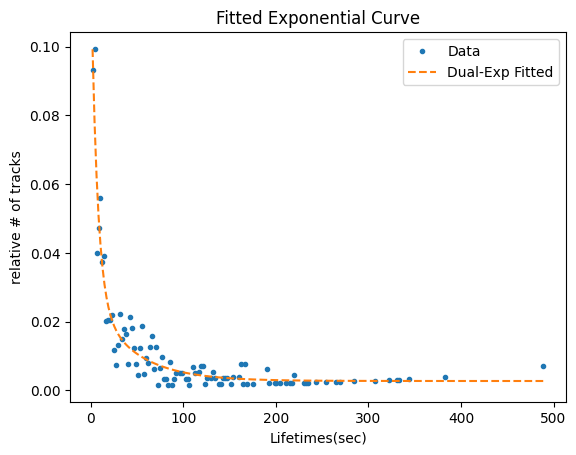

Y = 0.02453231291107048 * e^(-0.022715743059230912 * x) + 0.10069904820220084 * e^(-0.14962236945212656 * x) + 0.0027408062132830186
Tau1d = 44.02233276686204 s; Amplitude 1 = 0.02453231291107048
Tau2d = 6.683492606498 s; Amplitude 2 = 0.10069904820220084


In [11]:
#Define the dualexponential decay funciton
def duExp(x, a1d, t1d, a2d, t2d, b2):
    return a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2

# perform the dualexponential fit
xs = Track_Summary["Lifetime"]
ys = Track_Summary["Normalized track population"]
p0 = (Track_Summary["Normalized track population"].max(), .25, Track_Summary["Normalized track population"].max(), 1.25,0) # start with values near those we expect
poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0)
a1d, t1d, a2d, t2d, b2 = poptd
tau1dSec = 1 / t1d
tau2dSec = 1 / t2d

# determine quality of the dualexponential fit
squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² of dual exponential fitting= {rSquared}")

# plot the dualexponential fit results
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, duExp(xs, a1d, t1d, a2d, t2d, b2), '--', label="Dual-Exp Fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()
plt.show()

# inspect the dualexponential parameters
print(f"Y = {a1d} * e^(-{t1d} * x) + {a2d} * e^(-{t2d} * x) + {b2}")
print(f"Tau1d = {tau1dSec * 1} s; Amplitude 1 = {a1d}")
print(f"Tau2d = {tau2dSec * 1} s; Amplitude 2 = {a2d}")

### 3.2.1. Plot frequency vs lifetime of the dual exponential model

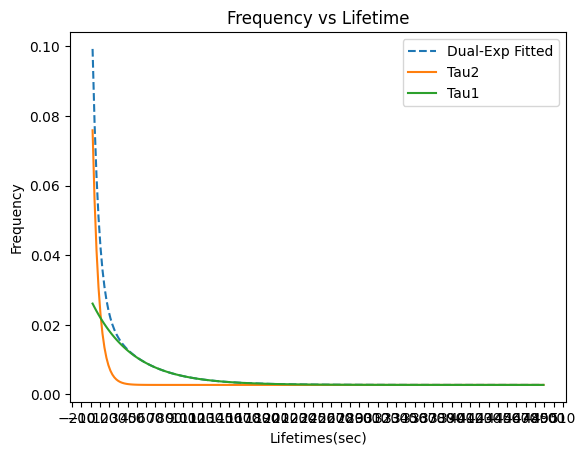

In [12]:
# Plot frequency vs lifttime
def monoExp(x, a1, t1, b1):
    return a1 * np.exp(-t1 * x) + b1

plt.plot(xs, duExp(xs, a1d, t1d, a2d, t2d, b2), '--', label="Dual-Exp Fitted")
plt.plot(xs, monoExp(xs, a2d, t2d,b2), '-', label="Tau2")
plt.plot(xs, monoExp(xs, a1d, t1d,b2), '-', label="Tau1")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Frequency")
plt.title("Frequency vs Lifetime")
x_major_locator = MultipleLocator(10)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.legend()
plt.show()